# Home work 2 

[Dataset](https://www.kaggle.com/danielgrijalvas/movies/version/2)


## Evaluation

1. Preprocessing of dataset, explaination what column do you use, why, In you skip any column explain why. Please analize usage of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and/or [TF-IDF Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).You allow to use external sources. 
2. K-means. Find the best param: number of clusters `n_clusters` (train muptiple models choose the best one). Show that you trained at least two k-means models (train kmeans for dataset with features received by CountVectorizer/TF-IDF Vectorizer and without). The 
3. Visualize cluster for the best model (2D case, you are allowed to use t-SNE or PCA if you want, not compulsory though)
4. DBScan. Find the best params: epsilon `eps` and minimum number of samples `min_samples`(train muptiple models choose the best one). Show that you trained at least two dbscan models (train dbscan for dataset with features received by CountVectorizer/TF-IDF Vectorizer and without)
5. Visualize clusters for the best model (2D case, you are allowed to use t-SNE or PCA if you want, not compulsory though)
6. Summary for both approaches (describe the model accuracy, performance, score, etc.)

## Additional Info

Sklearn K-means class has property - `inertia_` sum of squared distances of samples to their closest cluster center. Could be used for comparison.

[Here](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py) is example how you can compare two clustering approaches

[Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)- method of interpretation and validation of consistency within clusters of data [from wiki](https://en.wikipedia.org/wiki/Silhouette_(clustering))

t-SNE - method to reduce the dimensionality down to 2 dimenions, check the [kaggle kernel](https://www.kaggle.com/ffisegydd/cluster-analysis-of-movies-data) for example

## Submit

Two options for submition: via email or on [distedu.ukma.edu.ua](https://distedu.ukma.edu.ua/course/view.php?id=32)

You should submit jupyter notebook by Sunday, November 18th till 11:55 pm EEST timezone.


## Bonus points

Hierarchical clustering. Find best params. Dendogram and explanation.
Try all four merge strategies (complete, average, single linkages and ward criteria)
(8 points)



# Step1: Initialization, reading input


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from collections import Counter
%matplotlib inline

In [2]:
temp_data = pd.read_csv("movies.csv")


# Step2: Data exploration & preprocessing

Some simple exploration:

In [3]:
temp_data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [4]:
temp_data.describe()

,budget,gross,runtime,score,votes,year
count,6.820000e+03,6.820000e+03,6820.00000,6820.000000,6.820000e+03,6820.000000
mean,2.458113e+07,3.349783e+07,106.55132,6.374897,7.121952e+04,2001.000293
std,3.702254e+07,5.819760e+07,18.02818,1.003142,1.305176e+05,8.944501
min,0.000000e+00,7.000000e+01,50.00000,1.500000,2.700000e+01,1986.000000
25%,0.000000e+00,1.515839e+06,95.00000,5.800000,7.665250e+03,1993.000000
50%,1.100000e+07,1.213568e+07,102.00000,6.400000,2.589250e+04,2001.000000
75%,3.200000e+07,4.006534e+07,115.00000,7.100000,7.581225e+04,2009.000000
max,3.000000e+08,9.366622e+08,366.00000,9.300000,1.861666e+06,2016.000000


In [44]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
budget      6820 non-null float64
company     6820 non-null object
country     6820 non-null object
director    6820 non-null object
genre       6820 non-null object
gross       6820 non-null float64
name        6820 non-null object
rating      6820 non-null object
released    6820 non-null object
runtime     6820 non-null int64
score       6820 non-null float64
star        6820 non-null object
votes       6820 non-null int64
writer      6820 non-null object
year        6820 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


No nulls, everything except object-typed values seems OK.<br>
Let's check how many unique values each category has

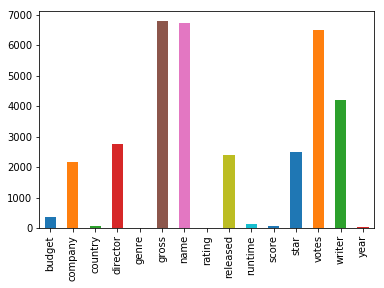

In [217]:
temp_data.nunique().plot.bar()

Some features have pretty low amount of unique values (genre, country, year). Others(vote, name, gross) are almost all unique.<br>
Let's look how unique values are distributed among different categories(company/country/genre/rating)

In [218]:
#special func to make data more informative
def show_dist(series,title,threshold):
    temp,cnt,num = pd.Series(),0,0
    #not really effective, but the idea was to create that 'other' category
    for i in series.index:
        if series[i]<threshold:
            num+=series[i]
            cnt+=1
        else:
            temp[i]=series[i]
    temp['Other'] = num
    text = "Index 'Other' contains "+str(cnt)+" indexes"
    plt.figure(1,figsize=(8,8))
    plt.bar(temp.index,temp.values)
    plt.suptitle(title+'\n'+text)
    #plt.xlabel(text)
    plt.xticks(rotation='vertical')
    plt.show()

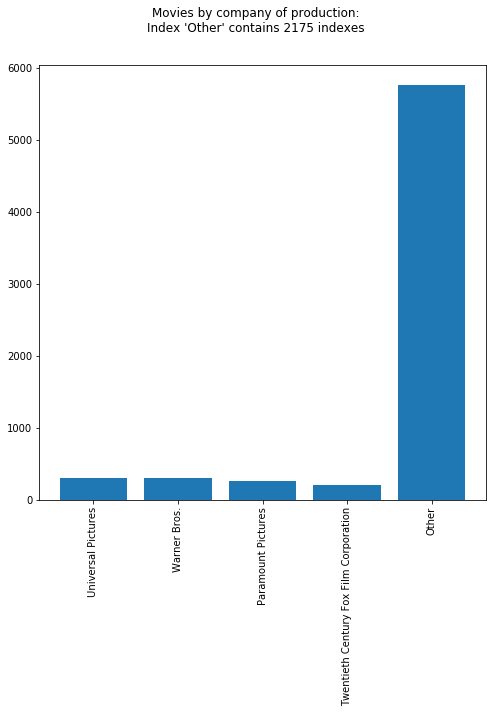

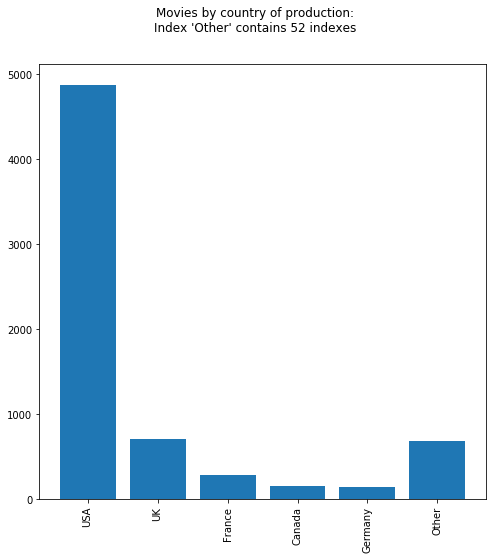

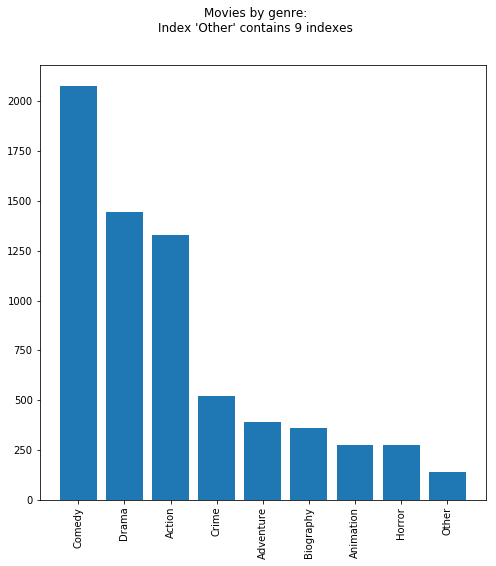

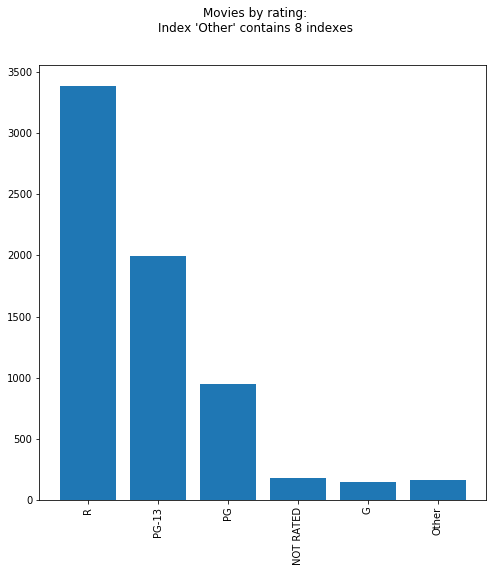

In [219]:
categories = [
    #category_name - category_description - threshold
    #threshold is chosen manually
    
    ["company","Movies by company of production:",200],
    ["country","Movies by country of production:",100],
    ["genre","Movies by genre:",100],
    ["rating","Movies by rating:",100]
]
for category in categories:
    naming,title, threshold = category    
    show_dist(temp_data[naming].value_counts(),title,threshold)

As you may see, most features with relatively few categories (i.e. rating, genre) have a dominant category, which sometimes consists of more elements than all other categories of that feature.<br>
Special category is a year, because all the values are spread evenly<br>
Some numerical categories (especially, score, can be normalized and transformed into categories with discrete number of values ) 

In [121]:
#possibly useful normalization function
def normalize(dataframe,cols):
    temp = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dataframe[cols]))
    dataframe[cols] = temp
    return dataframe

In [265]:
#let's test it. We'll be using: budget,gross,runtime,score,votes
columns = ['budget','gross','runtime','score']
test_df_normalized = normalize(temp_data,columns)
test_df_normalized.head()
#seems legit

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,0.026667,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,0.055823,Stand by Me,R,1986-08-22,0.123418,0.846154,Wil Wheaton,299174,Stephen King,1986
1,0.020000,Paramount Pictures,USA,John Hughes,Comedy,0.074879,Ferris Bueller's Day Off,PG-13,1986-06-11,0.167722,0.807692,Matthew Broderick,264740,John Hughes,1986
2,0.050000,Paramount Pictures,USA,Tony Scott,Action,0.191959,Top Gun,PG,1986-05-16,0.189873,0.692308,Tom Cruise,236909,Jim Cash,1986
3,0.061667,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,0.090919,Aliens,R,1986-07-18,0.275316,0.884615,Sigourney Weaver,540152,James Cameron,1986
4,0.030000,Walt Disney Pictures,USA,Randal Kleiser,Adventure,0.019820,Flight of the Navigator,PG,1986-08-01,0.126582,0.692308,Joey Cramer,36636,Mark H. Baker,1986


Certain columns should be tf-idf vectorized, others may simply be grouped by<br>
We won't group by 'director','star','writer', hence it's absolutely sensless to generate up to 12k features<br>
We won't tokenize these features by words: grouping David Lynch and David Yates by their name is absolutely nonsentical.However, it would be nice if we can use this data later.


In fact, I don't see any sense to group any column by words: let's look at a distribution of words met in a column "company" and then analyze a column "name": 

In [262]:
def explore_column_by_words(column,threshold=100):
    #adding something to pd.Series ain't efficient at all, but its a good way to generate a new words table step by step
    temp = pd.Series(temp_data[column].str.split())
    #small list of words to ignore
    stopwords = ["the","of","and","in","to","el","la","de","a","&","on","for","2","2:","3","I","II","III"]
    words = pd.Series()
    for line in temp:
        for word in line:
            if word.lower() not in stopwords:
                if word in words:
                    words[word]+=1
                else:
                    words[word]=1
    print("Total words:", words.count())
    print("Unique words:",words.nunique(),"\n\nWords by frequency:\n")
    print(words.sort_values(ascending=False))
    show_dist(words,"Words by frequency",threshold)


Total words: 2594
Unique words: 77 

Words by frequency:

Pictures               1838
Films                   799
Entertainment           720
Productions             606
Film                    465
Corporation             441
Fox                     337
Warner                  306
Universal               305
Bros.                   300
Columbia                282
Paramount               273
Century                 220
Twentieth               212
New                     207
Cinema                  192
Line                    186
Touchstone              131
Company                 127
Disney                  121
Walt                    116
DreamWorks              101
Metro-Goldwyn-Mayer     101
(MGM)                   101
Group                    97
TriStar                  87
Studios                  87
International            81
Screen                   79
Miramax                  77
                       ... 
Moviola                   1
och                       1
Eikon             

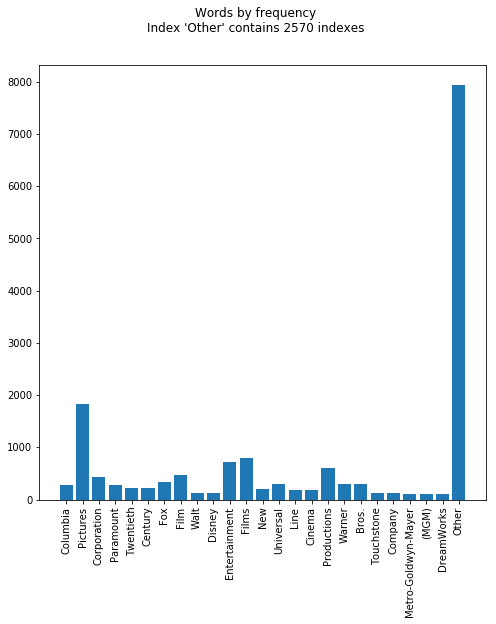

In [264]:
explore_column_by_words("company")

Most common words are "Pictures", "Films", "Entertainment", etc. Using tf-idf by this words will give us no clue except for a dataset with some share of arthouse studios. In an existing dataset grouping movies by these words is senseless.<br>
Maybe the only column will be 'name'?

Total words: 6606
Unique words: 49 

Words by frequency:

Man               95
Love              78
My                68
I                 61
Me                56
Movie             51
with              51
Dead              49
You               47
Night             46
Last              42
Girl              42
II                41
House             41
Life              40
Little            40
Black             37
Day               36
Big               36
American          35
White             35
Good              34
It                33
Mr.               33
Men               32
Out               32
Is                31
One               30
Time              30
City              30
                  ..
embargo            1
Crimen             1
Austen             1
Retrato            1
Corner             1
Bent               1
1600               1
Emporium           1
Related            1
Nightwatch         1
Assignment         1
Booty              1
Fatboy,            1
Gridlock'd        

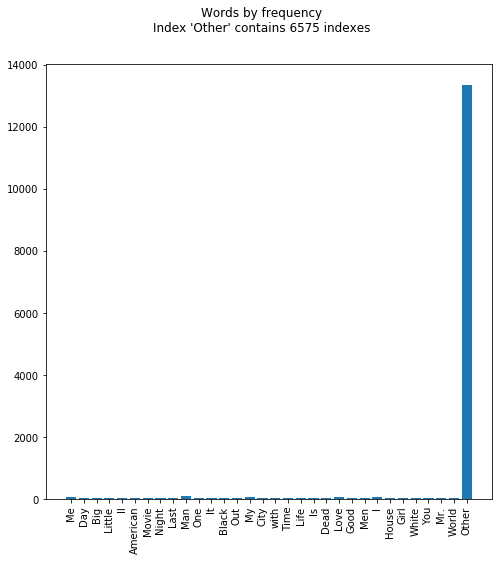

In [263]:
#we ignored some most typical words and set threshold at 30
explore_column_by_words("name",30)

No, it won't. 

In [ ]:
#Preprocessing: TF IDF vectorizer; Count Vectorizer
#K-Means
#cluster visualization for rbest
#DBscan, visualization
#Summary

